# Table of Contents
- [Data Preparation](#data-preparation)
  - [1. Loading a Dummy Dataset](#1-loading-a-dummy-dataset)
    - [1.1. Creating Temporary Transforms](#11-creating-temporary-transforms)
    - [1.2. Loading the Data](#12-loading-the-data)
  - [2. Splitting the Data](#2-splitting-the-data)
  - [3. Calculating Mean and Standard Deviation for Each Channel on the Training Data](#3-calculating-mean-and-standard-deviation-for-each-channel-on-the-training-data)
  - [4. Defining Data Transformations and Loading the Dataset](#4-defining-data-transformations-and-loading-the-dataset)
- [Training Models](#training-models)
  - [1. First Model](#model-v1)
    - [Evaluating the Impact of Data Augmentation on Model Performance](#evaluating-the-impact-of-data-augmentation-on-model-performance)
    - [Converting Images to LUV Color Space](#converting-images-to-luv-color-space)
      - [Showing Samples](#showing-samples)
      - [Training the Model](#training-the-model)
  - [2. Second Model](#model-v2)
  - [3. ResNet18 (Transfer Learning)](#resnet18-transfer-learning)

---

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split, SubsetRandomSampler
import torch.optim as optim
from torch.optim.lr_scheduler import MultiStepLR, ReduceLROnPlateau, CyclicLR, OneCycleLR, StepLR

import torchvision
from torchvision import transforms
from torchvision.datasets import ImageFolder

import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import seaborn as sn
import pandas as pd

from tqdm.auto import tqdm
import random
import time

from sklearn.metrics import confusion_matrix, classification_report

from utils.manager import normalize, denormalize, show_samples, ModelManager
from utils.models import CNNModelV01, CNNModelV02

import os
import shutil

try:
    from torch_lr_finder import LRFinder
except:
    ! pip install torch_lr_finder
    from torch_lr_finder import LRFinder

import platform
print( f"MACHINE: {platform.machine()}" )
print( f"PROCESSOR: {platform.processor()}")

print( f"PYTHON VERSION: {platform.python_version()}" )
print( f"TORCH VERSION: {torch.__version__}" )
print( f"TORCHVISION VERSION: {torchvision.__version__}" )

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print( f"device: {device}" )

MACHINE: x86_64
PROCESSOR: x86_64
PYTHON VERSION: 3.10.14
TORCH VERSION: 2.4.0
TORCHVISION VERSION: 0.19.0
device: cuda


# Data Preparation

## 1.) Loading a dummy Dataset


Resizing images to a uniform shape, and calculating their mean and standard deviation to standardize inputs. This is crucial for optimizing model convergence

### 1.1) Creating Temporary Transforms


In [ ]:
temp_transform = transforms.Compose([transforms.Resize((64, 64)), 
                                     transforms.ToTensor()])

### 1.2) Loading the data

In [ ]:
root = '/kaggle/input/rcp-dataset/Train'
dummy_dataset = ImageFolder(root=root, transform=temp_transform)

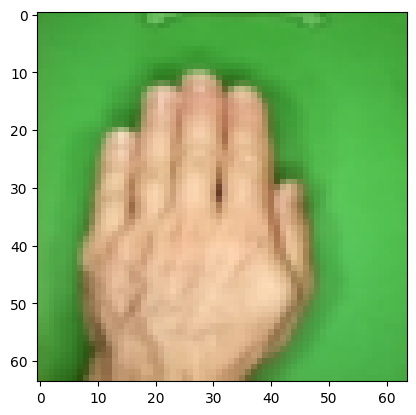

In [5]:
# Test the dataset
# display one random Image
i = random.choice(range(len(dummy_dataset)-1))
img, _ = dummy_dataset[i]

plt.imshow(img.permute(2, 1, 0).numpy())

## 2.) Splitting the Data

In [6]:
def index_splitter(n, splits=[80, 20], seed = 42):
    torch.manual_seed(seed)

    idx = torch.arange(n)
    splits = torch.as_tensor(splits)

    m = n/splits.sum()
    splits = (m*splits).long()

    diff = n - splits.sum()
    splits[0] += diff
    
    return random_split(idx, splits)

In [7]:
idx_train, idx_val = index_splitter(len(dummy_dataset))

In [8]:
train_sampler = SubsetRandomSampler(idx_train)
val_sampler = SubsetRandomSampler(idx_val)

In [9]:
dummy_train_dataloader = DataLoader(dataset=dummy_dataset, batch_size=32, sampler=train_sampler)

## 3.) Calculating Mean and Standard Deviation for Each Channel on the Training Data

In [11]:
normalizer = normalize(dummy_train_dataloader)

  0%|          | 0/120 [00:00<?, ?it/s]

In [12]:
normalizer

Normalize(mean=tensor([0.4800, 0.5386, 0.4236]), std=tensor([0.1888, 0.1406, 0.1567]))

## 4.)  Defining Data Transformations and Loading the Dataset

In [13]:
transform = transforms.Compose([transforms.Resize((64, 64)),
                               transforms.ToTensor(),
                               normalizer])

dataset = ImageFolder(root=root, transform=transform)

train_dataloader = DataLoader(dataset=dataset,
                             batch_size=32, 
                             sampler=train_sampler)

val_dataloader = DataLoader(dataset=dataset,
                           batch_size=32,
                           sampler=val_sampler)

# Training models

## Model v1

In [16]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)
model_v01 = CNNModelV01(in_channels=3, out_channels=4, n_filters=21)
optimizer_v01 = optim.Adam(lr=0.001, params=model_v01.parameters())
loss_fn = nn.CrossEntropyLoss(reduction='mean')
hc1 = ModelManager(model=model_v01, loss_fn=loss_fn, optimizer=optimizer_v01)
hc1.set_dataloaders(train_data=train_dataloader, val_data=val_dataloader)
hc1.set_filename('model_v1')

  0%|          | 0/100 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 3.51E-02


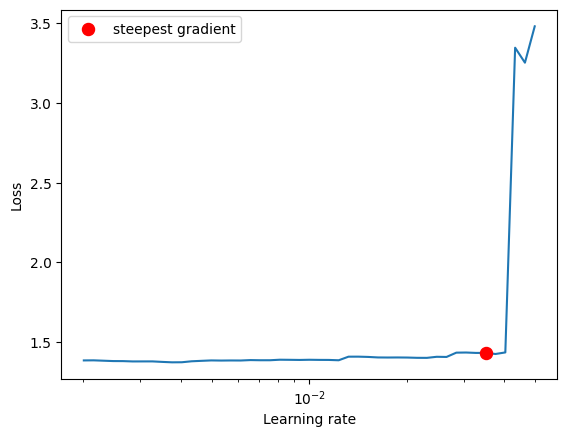

In [17]:
lr_finder = LRFinder(model_v01, optimizer_v01, loss_fn, device="cuda")
lr_finder.range_test(train_dataloader, end_lr=1, num_iter=100)
lr_finder.plot() # to inspect the loss-learning rate graph
lr_finder.reset() # to reset the model and optimizer to their initial state

In [18]:
lr_scheduler = ReduceLROnPlateau(optimizer_v01, patience=3, threshold=0.001)
# lr_scheduler = CyclicLR(optimizer_v01, base_lr=1e-05, max_lr=0.01,
#                        step_size_down=len(train_dataloader), mode='triangular2')
hc1.set_lr_scheduler(lr_scheduler)

In [19]:
hc1.train(15, print_loss=True)

  0%|          | 0/15 [00:00<?, ?it/s]

learning rate changed to --->  0.001
Epoch 1| train Loss: 1.3065 | acc. 31.79%                     | val Loss: 1.2460 | val acc. 40.91%
Epoch 2| train Loss: 1.1416 | acc. 53.53%                     | val Loss: 0.8769 | val acc. 62.76%
Epoch 3| train Loss: 0.7812 | acc. 75.00%                     | val Loss: 0.5848 | val acc. 78.21%
Epoch 4| train Loss: 0.5984 | acc. 83.65%                     | val Loss: 0.4822 | val acc. 83.03%
Epoch 5| train Loss: 0.5120 | acc. 86.54%                     | val Loss: 0.4495 | val acc. 83.37%
Epoch 6| train Loss: 0.4346 | acc. 88.96%                     | val Loss: 0.4043 | val acc. 85.76%
Epoch 7| train Loss: 0.3597 | acc. 91.56%                     | val Loss: 0.3889 | val acc. 85.90%
Epoch 8| train Loss: 0.3609 | acc. 92.47%                     | val Loss: 0.3782 | val acc. 87.28%
Epoch 9| train Loss: 0.2864 | acc. 94.64%                     | val Loss: 0.3575 | val acc. 86.83%
Epoch 10| train Loss: 0.2501 | acc. 95.63%                     | val Los

/tmp/ipykernel_30/1653653590.py:183: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(filename, map_location=torch.device(self.device))


              precision    recall  f1-score   support

           0       1.00      0.97      0.98      1043
           1       0.99      0.88      0.93       658
           2       0.98      0.99      0.99      1056
           3       0.92      1.00      0.96      1062

    accuracy                           0.97      3819
   macro avg       0.97      0.96      0.97      3819
weighted avg       0.97      0.97      0.97      3819



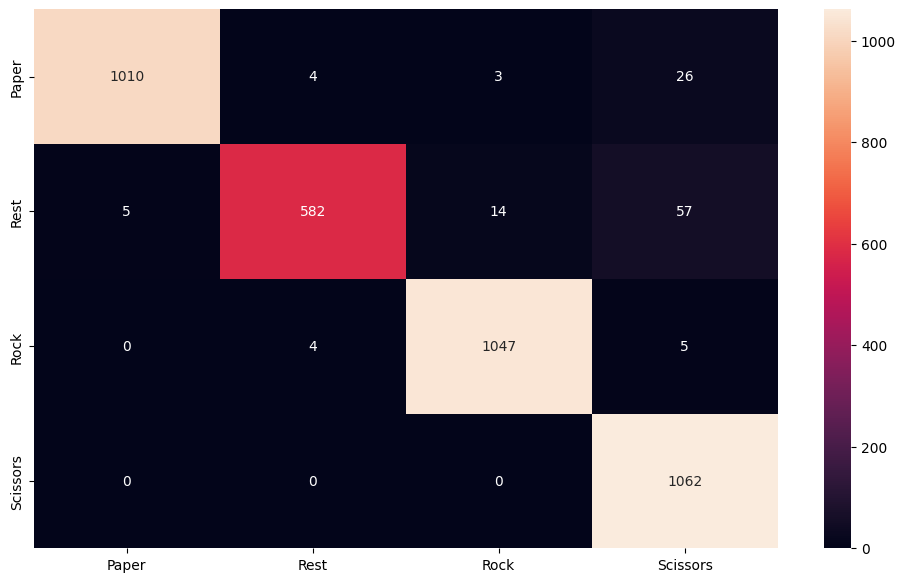

In [24]:
hc1.conf_mat_class_report(dataset.classes, report=True)

/tmp/ipykernel_30/1653653590.py:183: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(filename, map_location=torch.device(self.device))


              precision    recall  f1-score   support

           0       0.94      0.89      0.91       267
           1       0.88      0.65      0.75       177
           2       0.91      0.93      0.92       259
           3       0.80      0.98      0.88       251

    accuracy                           0.88       954
   macro avg       0.88      0.86      0.86       954
weighted avg       0.88      0.88      0.87       954



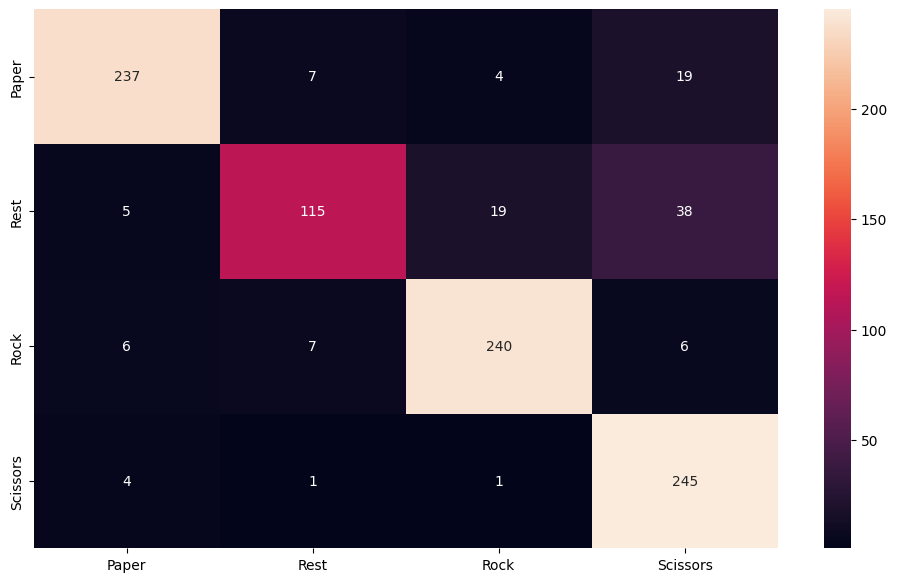

In [28]:
hc1.conf_mat_class_report(dataset.classes, validation = True, report=True)

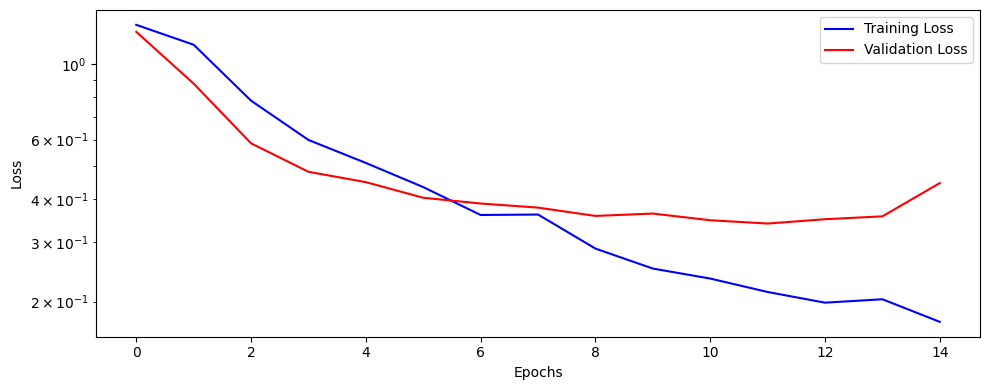

In [29]:
fig = hc1.plot_losses()

### Evaluating the Impact of Data Augmentation on Model Performance

In [14]:
transform = transforms.Compose([transforms.Resize((64, 64)),
                               transforms.ToTensor(),
                               normalizer,
                               transforms.RandomHorizontalFlip(0.5),
                               transforms.RandomAutocontrast(0.5),
                               transforms.RandomAffine(degrees=10, translate=(0.1,0.1)),
                               transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.1),
                               ])
dataset = ImageFolder(root=root, transform=transform)
train_data_augmentation = DataLoader(dataset=dataset, batch_size=32, sampler=train_sampler)
val_data_augmentation = DataLoader(dataset=dataset, batch_size=32, sampler=val_sampler)

In [46]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)
model_v02 = CNNModelV01(in_channels=3, out_channels=4, n_filters=21)
optimizer_v02 = optim.Adam(lr=0.001, params=model_v02.parameters())
loss_fn = nn.CrossEntropyLoss(reduction='mean')
mm = ModelManager(model=model_v02, loss_fn=loss_fn, optimizer=optimizer_v02)
mm.set_dataloaders(train_data=train_data_augmentation, val_data=val_data_augmentation)
mm.set_filename('model_v1_with_augmentation')

In [47]:
scheduler = ReduceLROnPlateau(optimizer_v02, patience=3, threshold=0.001)
mm.set_lr_scheduler(scheduler)

In [48]:
mm.train(15, print_loss=True)

  0%|          | 0/15 [00:00<?, ?it/s]

learning rate changed to --->  0.001
Epoch 1| train Loss: 1.3384 | acc. 30.10%                     | val Loss: 1.3024 | val acc. 30.95%
Epoch 2| train Loss: 1.2641 | acc. 40.34%                     | val Loss: 1.1395 | val acc. 44.27%
Epoch 3| train Loss: 1.0770 | acc. 51.08%                     | val Loss: 1.0216 | val acc. 52.12%
Epoch 4| train Loss: 0.9979 | acc. 57.02%                     | val Loss: 0.9651 | val acc. 55.96%
Epoch 5| train Loss: 0.9427 | acc. 61.73%                     | val Loss: 0.9150 | val acc. 60.39%
Epoch 6| train Loss: 0.9126 | acc. 62.92%                     | val Loss: 0.8724 | val acc. 63.74%
Epoch 7| train Loss: 0.8900 | acc. 66.10%                     | val Loss: 0.8415 | val acc. 63.74%
Epoch 8| train Loss: 0.8437 | acc. 69.04%                     | val Loss: 0.7915 | val acc. 68.61%
Epoch 9| train Loss: 0.8271 | acc. 71.38%                     | val Loss: 0.7362 | val acc. 71.16%
Epoch 10| train Loss: 0.7994 | acc. 70.89%                     | val Los

In [49]:
mm.train(30, print_loss=True)

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 16| train Loss: 0.6798 | acc. 77.11%                     | val Loss: 0.6320 | val acc. 74.67%
Epoch 17| train Loss: 0.6990 | acc. 76.93%                     | val Loss: 0.6365 | val acc. 76.28%
Epoch 18| train Loss: 0.6797 | acc. 77.64%                     | val Loss: 0.5834 | val acc. 76.68%
Epoch 19| train Loss: 0.6521 | acc. 78.19%                     | val Loss: 0.6362 | val acc. 75.98%
Epoch 20| train Loss: 0.6603 | acc. 77.95%                     | val Loss: 0.5664 | val acc. 77.56%
Epoch 21| train Loss: 0.6361 | acc. 78.96%                     | val Loss: 0.5585 | val acc. 77.25%
Epoch 22| train Loss: 0.6308 | acc. 78.97%                     | val Loss: 0.5680 | val acc. 78.08%
Epoch 23| train Loss: 0.6365 | acc. 79.85%                     | val Loss: 0.5733 | val acc. 78.14%
Epoch 24| train Loss: 0.6163 | acc. 79.93%                     | val Loss: 0.5403 | val acc. 79.28%
Epoch 25| train Loss: 0.6051 | acc. 80.45%                     | val Loss: 0.5274 | val acc. 79.13%


/tmp/ipykernel_30/1571887821.py:185: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(filename, map_location=torch.device(self.device))


              precision    recall  f1-score   support

           0       0.84      0.92      0.88      1043
           1       0.74      0.45      0.56       658
           2       0.83      0.94      0.88      1056
           3       0.90      0.90      0.90      1062

    accuracy                           0.84      3819
   macro avg       0.82      0.80      0.80      3819
weighted avg       0.83      0.84      0.83      3819



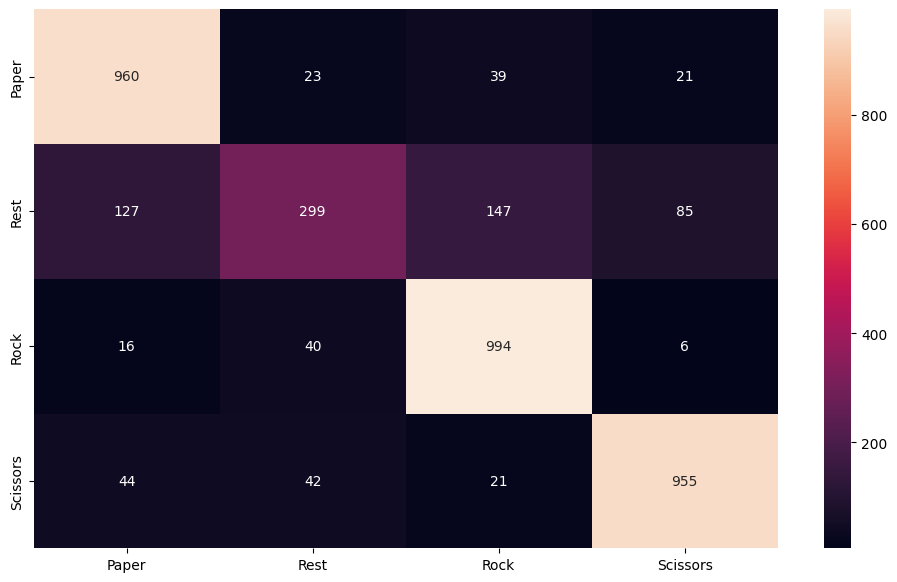

In [50]:
mm.conf_mat_class_report(dataset.classes, report=True)

/tmp/ipykernel_30/1571887821.py:185: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(filename, map_location=torch.device(self.device))


              precision    recall  f1-score   support

           0       0.83      0.93      0.87       267
           1       0.74      0.49      0.59       177
           2       0.83      0.94      0.88       259
           3       0.86      0.84      0.85       251

    accuracy                           0.83       954
   macro avg       0.81      0.80      0.80       954
weighted avg       0.82      0.83      0.82       954



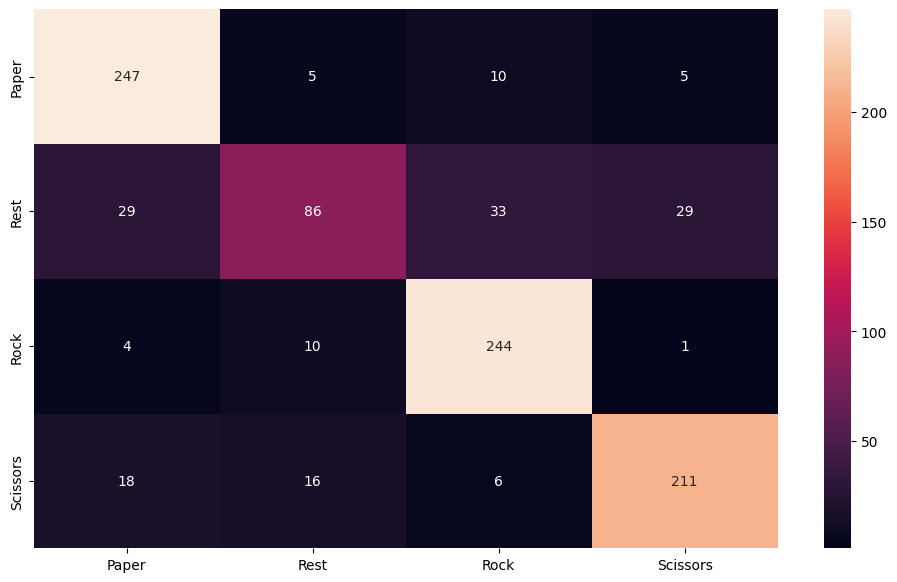

In [51]:
mm.conf_mat_class_report(dataset.classes, report=True, validation=True)

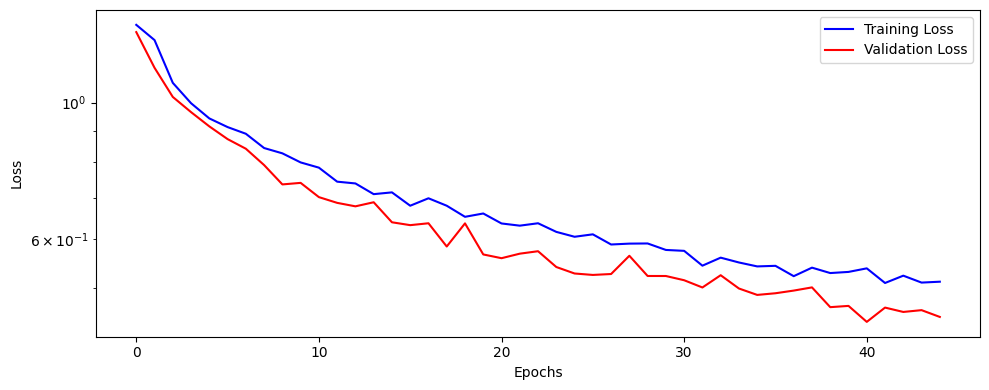

In [53]:
fig = mm.plot_losses()

### Converting Images to LUV Color Space

In [15]:
class ChangeColorSpace(object):
    def __call__(self, x):
        x = np.array(x, dtype='uint8')
        luv = cv2.cvtColor(x, cv2.COLOR_RGB2LUV)
        img = Image.fromarray(luv)
        return img

In [16]:
# load a temp dataset with the new color space to calculate the mean and std
temp_transform = transforms.Compose([transforms.Resize((64,64)),
                                     ChangeColorSpace(),
                                     transforms.ToTensor()])
temp_dataset = ImageFolder(root=root, transform=temp_transform)

temp_train_loader = DataLoader(dataset=temp_dataset,
                               batch_size=16,
                               sampler=train_sampler)

normalizer_luv = normalize(temp_train_loader)
normalizer_luv

  0%|          | 0/239 [00:00<?, ?it/s]

Normalize(mean=tensor([0.5578, 0.3708, 0.6041]), std=tensor([0.1379, 0.0530, 0.0404]))

In [17]:
transform = transforms.Compose([transforms.Resize((64, 64)),
                               ChangeColorSpace(),
                               transforms.ToTensor(),
                               normalizer_luv,
                               transforms.RandomHorizontalFlip(0.5),
                               transforms.RandomAutocontrast(0.5),
                               transforms.RandomAffine(degrees=10, translate=(0.1,0.1)),
                               transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.1),
                               ])
dataset = ImageFolder(root=root, transform=transform)
train_data_augmentation_luv = DataLoader(dataset=dataset, batch_size=32, sampler=train_sampler)
val_data_augmentation_luv = DataLoader(dataset=dataset, batch_size=32, sampler=val_sampler)

#### Showing Samples

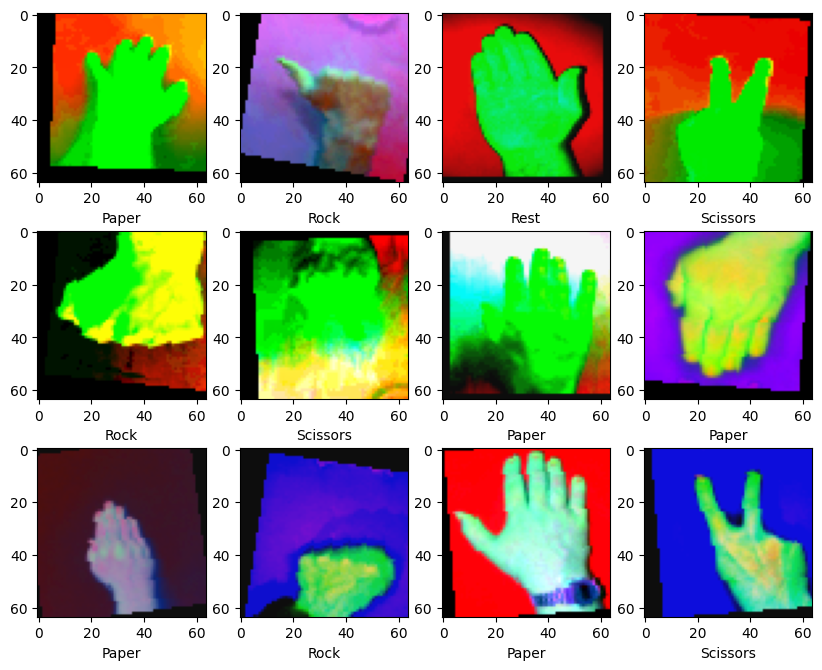

In [63]:
batch_images, batch_labels = next(iter(train_data_augmentation_luv))
show_samples(12, batch_images, batch_labels)

#### Training the Model

In [70]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)
model_v03 = CNNModelV01(in_channels=3, out_channels=4, n_filters=21)
optimizer_v03 = optim.Adam(lr=0.001, params=model_v03.parameters())
loss_fn = nn.CrossEntropyLoss(reduction='mean')
mm2 = ModelManager(model=model_v03, loss_fn=loss_fn, optimizer=optimizer_v03)
mm2.set_dataloaders(train_data=train_data_augmentation_luv, val_data=val_data_augmentation_luv)
mm2.set_filename('model_v1_with_augmentation_luv')
scheduler2 = ReduceLROnPlateau(optimizer_v03, patience=3, threshold=0.001)
mm2.set_lr_scheduler(scheduler2)

In [71]:
mm2.train(15, print_loss=True)

  0%|          | 0/15 [00:00<?, ?it/s]

learning rate changed to --->  0.001
Epoch 1| train Loss: 1.3394 | acc. 28.61%                     | val Loss: 1.3175 | val acc. 32.15%
Epoch 2| train Loss: 1.2752 | acc. 40.49%                     | val Loss: 1.1352 | val acc. 52.44%
Epoch 3| train Loss: 1.0256 | acc. 65.19%                     | val Loss: 0.8605 | val acc. 64.21%
Epoch 4| train Loss: 0.8464 | acc. 71.73%                     | val Loss: 0.7785 | val acc. 69.81%
Epoch 5| train Loss: 0.7609 | acc. 75.84%                     | val Loss: 0.6529 | val acc. 74.75%
Epoch 6| train Loss: 0.7092 | acc. 78.62%                     | val Loss: 0.5982 | val acc. 76.06%
Epoch 7| train Loss: 0.6602 | acc. 79.67%                     | val Loss: 0.5611 | val acc. 79.28%
Epoch 8| train Loss: 0.6174 | acc. 81.93%                     | val Loss: 0.5576 | val acc. 79.22%
Epoch 9| train Loss: 0.5926 | acc. 82.04%                     | val Loss: 0.5300 | val acc. 80.76%
Epoch 10| train Loss: 0.5728 | acc. 82.76%                     | val Los

In [72]:
mm2.train(30, print_loss=1)

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 16| train Loss: 0.4984 | acc. 85.94%                     | val Loss: 0.4391 | val acc. 83.81%
Epoch 17| train Loss: 0.4925 | acc. 85.29%                     | val Loss: 0.4384 | val acc. 83.13%
Epoch 18| train Loss: 0.4843 | acc. 85.97%                     | val Loss: 0.4202 | val acc. 84.05%
Epoch 19| train Loss: 0.4792 | acc. 85.53%                     | val Loss: 0.4382 | val acc. 85.14%
Epoch 20| train Loss: 0.4885 | acc. 86.23%                     | val Loss: 0.4135 | val acc. 83.91%
Epoch 21| train Loss: 0.4675 | acc. 86.56%                     | val Loss: 0.4311 | val acc. 84.41%
Epoch 22| train Loss: 0.4452 | acc. 87.06%                     | val Loss: 0.3984 | val acc. 84.82%
Epoch 23| train Loss: 0.4514 | acc. 86.60%                     | val Loss: 0.4002 | val acc. 84.25%
Epoch 24| train Loss: 0.4341 | acc. 87.27%                     | val Loss: 0.4138 | val acc. 84.72%
Epoch 25| train Loss: 0.4438 | acc. 87.37%                     | val Loss: 0.3780 | val acc. 86.49%


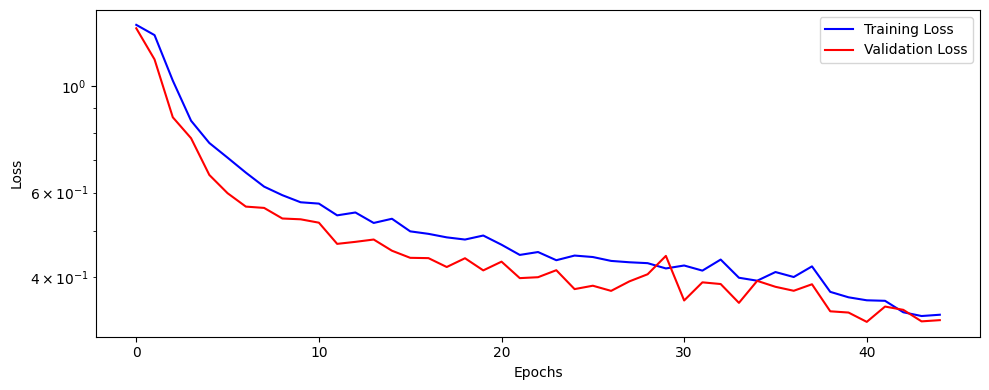

In [73]:
fig = mm2.plot_losses()

/tmp/ipykernel_30/1571887821.py:185: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(filename, map_location=torch.device(self.device))


              precision    recall  f1-score   support

           0       0.91      0.94      0.92      1043
           1       0.80      0.71      0.75       658
           2       0.92      0.95      0.93      1056
           3       0.92      0.94      0.93      1062

    accuracy                           0.90      3819
   macro avg       0.89      0.88      0.88      3819
weighted avg       0.90      0.90      0.90      3819



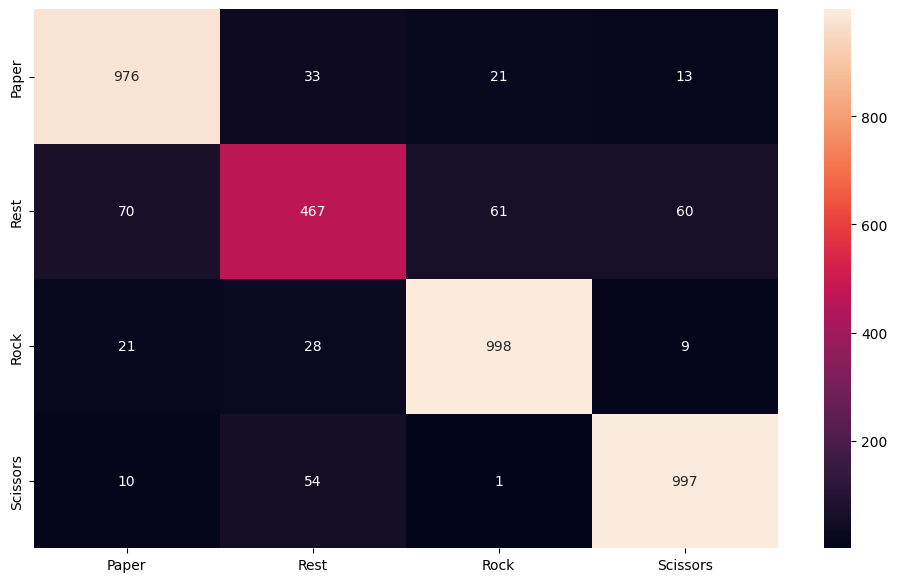

In [74]:
mm2.conf_mat_class_report(dataset.classes, report=True)

/tmp/ipykernel_30/1571887821.py:185: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(filename, map_location=torch.device(self.device))


              precision    recall  f1-score   support

           0       0.88      0.91      0.90       267
           1       0.79      0.69      0.74       177
           2       0.89      0.94      0.91       259
           3       0.90      0.91      0.91       251

    accuracy                           0.88       954
   macro avg       0.87      0.86      0.86       954
weighted avg       0.87      0.88      0.87       954



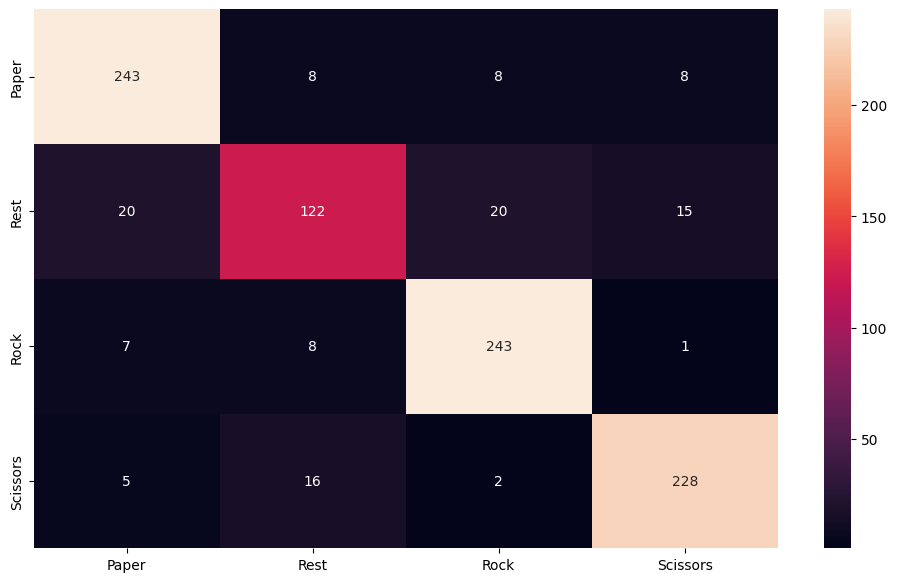

In [75]:
mm2.conf_mat_class_report(dataset.classes, report=True, validation=True)

The model demonstrates good performance with data in the LUV color space. Next, we will test a different model using this data!

## Model V2

In [ ]:
from utils.models import CNNModelV02

In [85]:
model_v04 = CNNModelV02(in_channels=3, out_channels=4, n_filters=15)
optimizer_v04 = optim.Adam(lr=0.001, params=model_v04.parameters())
loss_fn = nn.CrossEntropyLoss(reduction='mean')
mm3 = ModelManager(model=model_v04, loss_fn=loss_fn, optimizer=optimizer_v04)
mm3.set_dataloaders(train_data=train_data_augmentation_luv, val_data=val_data_augmentation_luv)
mm3.set_filename('model_v2_with_augmentation_luv')
scheduler3 = ReduceLROnPlateau(optimizer_v04, patience=3, threshold=0.001, factor=0.3)
mm3.set_lr_scheduler(scheduler3)

In [86]:
mm3.train(15, print_loss=1, seed=40)

  0%|          | 0/15 [00:00<?, ?it/s]

learning rate changed to --->  0.001
Epoch 1| train Loss: 1.7800 | acc. 32.72%                     | val Loss: 1.3128 | val acc. 33.45%
Epoch 2| train Loss: 1.2452 | acc. 47.85%                     | val Loss: 1.0736 | val acc. 56.69%
Epoch 3| train Loss: 0.9959 | acc. 63.16%                     | val Loss: 0.8797 | val acc. 63.74%
Epoch 4| train Loss: 0.8819 | acc. 67.96%                     | val Loss: 0.7870 | val acc. 68.19%
Epoch 5| train Loss: 0.8151 | acc. 71.44%                     | val Loss: 0.7573 | val acc. 67.88%
Epoch 6| train Loss: 0.7635 | acc. 73.84%                     | val Loss: 0.7105 | val acc. 72.46%
Epoch 7| train Loss: 0.7143 | acc. 76.18%                     | val Loss: 0.6205 | val acc. 75.49%
Epoch 8| train Loss: 0.6685 | acc. 78.26%                     | val Loss: 0.6268 | val acc. 76.30%
Epoch 9| train Loss: 0.6552 | acc. 78.31%                     | val Loss: 0.5739 | val acc. 76.60%
Epoch 10| train Loss: 0.6007 | acc. 81.80%                     | val Los

In [87]:
mm3.train(15, print_loss=1, seed=40)

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch 16| train Loss: 0.5343 | acc. 84.04%                     | val Loss: 0.4741 | val acc. 82.09%
Epoch 17| train Loss: 0.5320 | acc. 83.86%                     | val Loss: 0.4775 | val acc. 81.70%
Epoch 18| train Loss: 0.5152 | acc. 84.43%                     | val Loss: 0.4820 | val acc. 81.91%
learning rate changed to --->  0.0003
Epoch 19| train Loss: 0.4980 | acc. 85.38%                     | val Loss: 0.4842 | val acc. 80.84%
Epoch 20| train Loss: 0.4579 | acc. 85.94%                     | val Loss: 0.4220 | val acc. 84.21%
Epoch 21| train Loss: 0.4557 | acc. 85.97%                     | val Loss: 0.4481 | val acc. 83.14%
Epoch 22| train Loss: 0.4468 | acc. 86.23%                     | val Loss: 0.4166 | val acc. 84.79%
Epoch 23| train Loss: 0.4465 | acc. 86.72%                     | val Loss: 0.4144 | val acc. 83.53%
Epoch 24| train Loss: 0.4035 | acc. 87.66%                     | val Loss: 0.4139 | val acc. 84.41%
Epoch 25| train Loss: 0.4373 | acc. 86.54%                    

## ResNet18 (Transfer Learning)

In [ ]:
from torchvision.models import resnet18
from torchvision.models.resnet import ResNet18_Weights

In [31]:
resnet = resnet18(weights=ResNet18_Weights.DEFAULT)

In [22]:
print(resnet)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [32]:
resnet.fc = nn.Linear(512, 4)

In [98]:
transform_resnet = transforms.Compose([transforms.Resize((256, 256)),
                               ChangeColorSpace(),
                               transforms.ToTensor(),
                               transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                               transforms.RandomHorizontalFlip(0.5),
                               transforms.RandomAutocontrast(0.5),
                               transforms.RandomAffine(degrees=10, translate=(0.1,0.1)),
                               transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.1),
                               ])
dataset = ImageFolder(root=root, transform=transform_resnet)
train_data_resnet_luv = DataLoader(dataset=dataset, batch_size=32, sampler=train_sampler)
val_data_resnet_luv = DataLoader(dataset=dataset, batch_size=32, sampler=val_sampler)

In [99]:
optimizer_v05 = optim.Adam(lr=0.003, params=resnet.parameters())
loss_fn = nn.CrossEntropyLoss(reduction='mean')
mm4 = ModelManager(model=resnet, loss_fn=loss_fn, optimizer=optimizer_v05)
mm4.set_dataloaders(train_data=train_data_resnet_luv, val_data=val_data_resnet_luv)
mm4.set_filename('resnet_with_augmentation_luv')
scheduler4 = ReduceLROnPlateau(optimizer_v05, patience=4, threshold=0.001, factor=0.3)
mm4.set_lr_scheduler(scheduler4)

In [100]:
mm4.train(10, print_loss=1)

  0%|          | 0/10 [00:00<?, ?it/s]

learning rate changed to --->  0.003
Epoch 1| train Loss: 0.4084 | acc. 79.82%                     | val Loss: 0.5832 | val acc. 80.79%
Epoch 2| train Loss: 0.3149 | acc. 88.93%                     | val Loss: 0.4652 | val acc. 84.57%
Epoch 3| train Loss: 0.2790 | acc. 90.76%                     | val Loss: 0.3586 | val acc. 87.61%
Epoch 4| train Loss: 0.2549 | acc. 93.10%                     | val Loss: 0.3523 | val acc. 86.96%
Epoch 5| train Loss: 0.1977 | acc. 95.00%                     | val Loss: 0.3041 | val acc. 90.31%
Epoch 6| train Loss: 0.2053 | acc. 95.00%                     | val Loss: 0.2028 | val acc. 93.52%
Epoch 7| train Loss: 0.1815 | acc. 95.99%                     | val Loss: 0.2797 | val acc. 89.54%
Epoch 8| train Loss: 0.1890 | acc. 95.00%                     | val Loss: 0.2351 | val acc. 92.40%
Epoch 9| train Loss: 0.1657 | acc. 95.94%                     | val Loss: 0.1778 | val acc. 94.22%
Epoch 10| train Loss: 0.1881 | acc. 95.44%                     | val Los

In [101]:
mm4.train(10, print_loss=1)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 11| train Loss: 0.1456 | acc. 96.35%                     | val Loss: 0.2081 | val acc. 92.87%
Epoch 12| train Loss: 0.1662 | acc. 96.07%                     | val Loss: 0.1735 | val acc. 93.53%
Epoch 13| train Loss: 0.1530 | acc. 96.80%                     | val Loss: 0.1782 | val acc. 94.35%
Epoch 14| train Loss: 0.1268 | acc. 97.45%                     | val Loss: 0.1485 | val acc. 94.56%
Epoch 15| train Loss: 0.1439 | acc. 97.06%                     | val Loss: 0.1518 | val acc. 94.77%
Epoch 16| train Loss: 0.1369 | acc. 96.82%                     | val Loss: 0.1972 | val acc. 92.80%
Epoch 17| train Loss: 0.1287 | acc. 97.50%                     | val Loss: 0.1843 | val acc. 93.39%
Epoch 18| train Loss: 0.1243 | acc. 96.67%                     | val Loss: 0.2433 | val acc. 91.02%
learning rate changed to --->  0.0009
Epoch 19| train Loss: 0.1337 | acc. 97.16%                     | val Loss: 0.1539 | val acc. 94.95%
Epoch 20| train Loss: 0.0812 | acc. 97.92%                    

In [102]:
mm4.train(10, print_loss=1)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 21| train Loss: 0.0638 | acc. 98.31%                     | val Loss: 0.0760 | val acc. 96.98%
Epoch 22| train Loss: 0.0452 | acc. 98.91%                     | val Loss: 0.0794 | val acc. 97.08%
Epoch 23| train Loss: 0.0469 | acc. 99.22%                     | val Loss: 0.1006 | val acc. 96.75%
Epoch 24| train Loss: 0.0512 | acc. 98.96%                     | val Loss: 0.0845 | val acc. 96.77%
Epoch 25| train Loss: 0.0425 | acc. 99.22%                     | val Loss: 0.0982 | val acc. 96.56%
learning rate changed to --->  0.00027
Epoch 26| train Loss: 0.0434 | acc. 99.06%                     | val Loss: 0.1105 | val acc. 95.60%
Epoch 27| train Loss: 0.0272 | acc. 99.38%                     | val Loss: 0.0920 | val acc. 97.19%
Epoch 28| train Loss: 0.0263 | acc. 99.27%                     | val Loss: 0.0781 | val acc. 97.29%
Epoch 29| train Loss: 0.0242 | acc. 99.56%                     | val Loss: 0.0793 | val acc. 97.40%
Epoch 30| train Loss: 0.0200 | acc. 99.69%                   

In [104]:
mm4.train(10, print_loss=1)

  0%|          | 0/10 [00:00<?, ?it/s]

learning rate changed to --->  8.1e-05
Epoch 31| train Loss: 0.0275 | acc. 99.61%                     | val Loss: 0.0893 | val acc. 96.93%
Epoch 32| train Loss: 0.0178 | acc. 99.69%                     | val Loss: 0.0825 | val acc. 97.16%
Epoch 33| train Loss: 0.0225 | acc. 99.61%                     | val Loss: 0.0692 | val acc. 97.56%
Epoch 34| train Loss: 0.0208 | acc. 99.51%                     | val Loss: 0.0947 | val acc. 96.85%
Epoch 35| train Loss: 0.0220 | acc. 99.56%                     | val Loss: 0.0714 | val acc. 97.81%
Epoch 36| train Loss: 0.0208 | acc. 99.43%                     | val Loss: 0.0999 | val acc. 97.08%
Epoch 37| train Loss: 0.0171 | acc. 99.74%                     | val Loss: 0.0813 | val acc. 97.60%
learning rate changed to --->  2.43e-05
Epoch 38| train Loss: 0.0174 | acc. 99.77%                     | val Loss: 0.0981 | val acc. 97.27%
Epoch 39| train Loss: 0.0187 | acc. 99.71%                     | val Loss: 0.0711 | val acc. 97.50%
Epoch 40| train Loss:

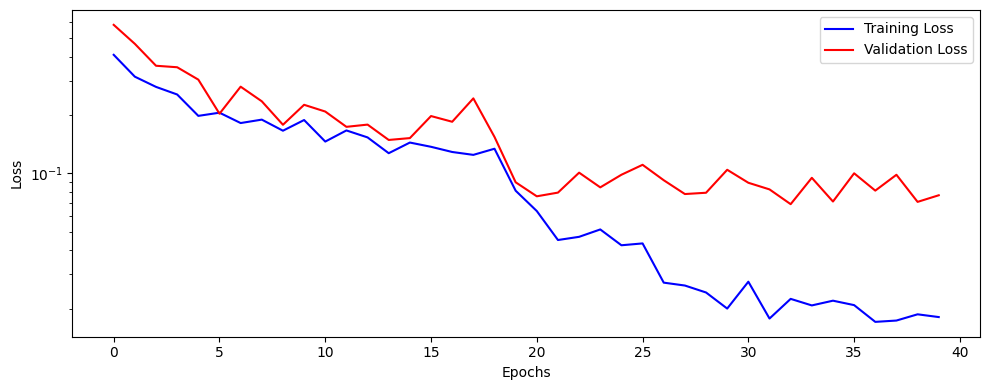

In [105]:
fig = mm4.plot_losses()

/tmp/ipykernel_30/1571887821.py:185: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(filename, map_location=torch.device(self.device))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1043
           1       0.99      1.00      0.99       658
           2       1.00      1.00      1.00      1056
           3       1.00      1.00      1.00      1062

    accuracy                           1.00      3819
   macro avg       1.00      1.00      1.00      3819
weighted avg       1.00      1.00      1.00      3819



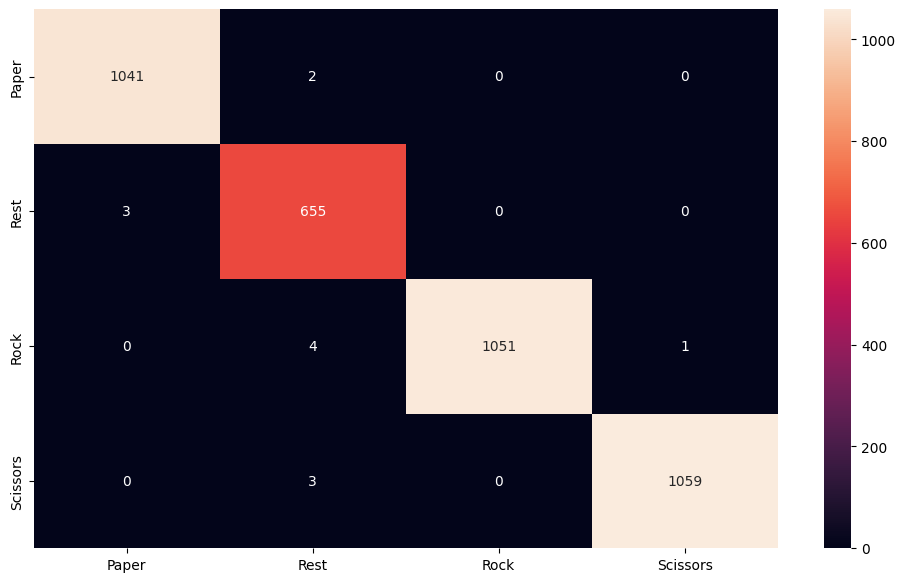

In [106]:
mm4.conf_mat_class_report(dataset.classes, report=True)

/tmp/ipykernel_30/1571887821.py:185: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(filename, map_location=torch.device(self.device))


              precision    recall  f1-score   support

           0       0.99      0.99      0.99       267
           1       0.91      0.95      0.93       177
           2       0.98      0.97      0.98       259
           3       1.00      0.98      0.99       251

    accuracy                           0.97       954
   macro avg       0.97      0.97      0.97       954
weighted avg       0.97      0.97      0.97       954



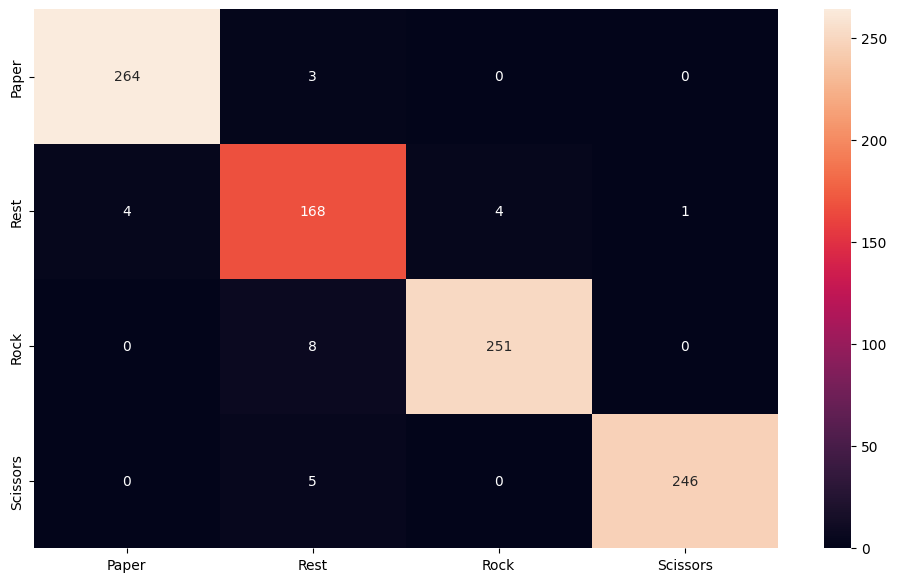

In [107]:
mm4.conf_mat_class_report(dataset.classes, report=True, validation=True)